#Склонностная модель

Выполнила: Андреичева Полина

**Постановка задачи**

Для начала необходимо определиться с постановкой задачи - метриками качеста и желаемыми результатами. Предсказание с лучшей точностью (96%) будет константа 0, однако точность предсказания 1 данной модели будет 0%. Поэтому для выбора метрики оценивания  рассмотрена похожая задача о предсказании совершения заказа из статьи ["Can You Predict If a Customer Will Make a Purchase on a Website?"](https://towardsdatascience.com/can-you-predict-if-a-customer-will-make-a-purchase-on-a-website-e6843ec264ae).
Взяты те же метрики для оценивания качества предсказания, что в статье - площадь под ROC-кривой (ROC AUC) и  точность (Accuracy), а также ориентировочное качество для сопоставления качества моделей:
  

*   ROC AUC - 89.3%
*   Accuracy - 0.773


Однако, процент конверсии в статье составляет 9%, в предоставленных данных - 4%, поэтому следует ожидать снижения качества.

Метрика AUC оценивает дискриминационную способность модели, и в бинарном случае формула для её исчисления равна:

$$AUC=\frac{1+TPR-FPR}{2}$$

Как правило, приемлимыми значениями считаются значения от 0.7 до 0.8. Более высокие значения говорят об отличном качестве модели. Таким образом было оценено приемлимое качество модели.

**Особенности данных**

В предоставленных данных есть две особенности: несбалансированность данных и малое количество переменных, все из которых категориальные.

Для исправления проблемы несбалансированных данных была проведена ребалансировка выборки при помощи библиотеки SMOTE. Для всех моделей  удаление части наблюдений (до соотношения 6:10) из класса "0" стало лучшей стратегией.

Для улучшения качества модели построено несколько переменных, так как количество доступных переменных достаточно мало. Кроме того, модели лучше работают, если им предоставить несколько разных построенных переменных для поиска сложных связей между ними. Таким образом, сделано следующее:

1. Добавлены дамми-переменные для всех категориальных переменных.
2. Целе-вероятностное кодирование переменных: добавлены переменные, в которых категория заменена на процент единичных значений в данной категории.
3. Корректирование категориальных значений так, чтобы сохранялась логика в значениях: значение переменной повышалось с повышением процента единичных значений в категории.


In [193]:
import numpy as np
import pandas as pd

In [194]:
data = pd.read_csv('analytics.csv', index_col=None, names=['feature'+ str(x) for x in range(8)])

In [195]:
# Создание дамми-переменных
categorical_cols=['feature0', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6']
df = pd.get_dummies(data, columns = categorical_cols)

In [196]:
# Выделение таргета
y=data['feature7']
X=data.drop('feature7',axis=1)

In [197]:
# Разделение выборки на тренировочную (72%), валидационную (8%) и тестовую (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

***Распределение наблюдений***
\begin{array}{|c|c|} \hline
& Train & Validation & Test \\ \hline
Count & 90561 & 10063 & 25156 \\
Percentage & .72 & .8 & .20 \\
Conversion & 3.9 & 3.3 & 3.7 \\
 \hline
\end{array}

## Feature Engineering

Так как количество переменных ограничено, желательно сохранение как можно большего количества информации. Поэтому при обнаружении значений, которые нарушают логику переменной как, например, категория 6 в переменной 0, это значение корректируется в соответствии с процентом единичных значений таргета в этой переменной. 

Это, возможно, затруднит интерпретацию, но так как основная цель задания - это предсказание, и все категориальные переменные кроме feature2 похожи на порядковые, выполнены упомянутые выше коррекции.

Все действия, связанные с построением переменных, основаны только на информации из обучающей выборки, чтобы избежать утечки информации из тестовой выборки.

Данная процедура, а также целе-вероятностное кодирование переменных позволили повысить значение ROC AUC с .70 до .75.

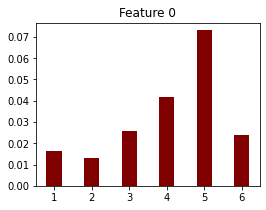

In [198]:
# построение графика, где столбец означет значение категориальной переменной, 
# а высота столбца равна проценту содержания значений 1 в данной категории
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(X_train['feature0']):
  a.append(x)
  b.append(sum(y_train[X_train['feature0']==x]/len(X_train[X_train['feature0']==x])))
  plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 0")
plt.show()

На примере данного случая можно заметить, как одна категория (6) нарушает зависимость между категориями и процентов совершенных заказов. Такие значения скорректированы, чтобы упростить работу моделей в дальнейшем. Результат такой коррекции можно увидеть в конце данного раздела.

In [199]:
# корректирование переменной для сохранения логики 
data['feature0'][data['feature0']==6] = 2.5

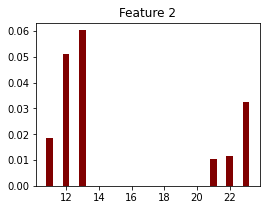

In [200]:
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(data['feature2']):
  a.append(x)
  b.append(sum(data['feature7'][data['feature2']==x])/len(data[data['feature2']==x]))
plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 2")
plt.show()

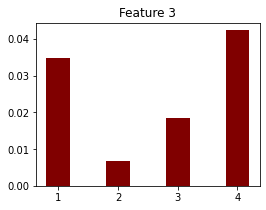

In [201]:
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(X_train['feature3']):
  a.append(x)
  b.append(sum(y_train[X_train['feature3']==x]/len(X_train[X_train['feature3']==x])))
plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 3")
plt.show()

In [ ]:
data['feature3'][data['feature3']==1] = 3.5

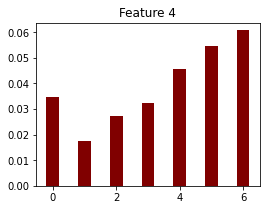

In [203]:
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(data['feature4']):
  a.append(x)
  b.append(sum(data['feature7'][data['feature4']==x]/len(data[data['feature4']==x])))
plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 4")
plt.show()

In [ ]:
data['feature4'][data['feature4']==0] = 3.5

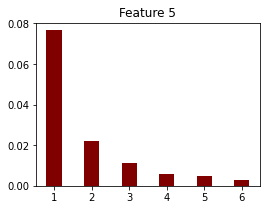

In [205]:
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(data['feature5']):
  a.append(x)
  b.append(sum(data['feature7'][data['feature5']==x]/len(data[data['feature5']==x])))
plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 5")
plt.show()

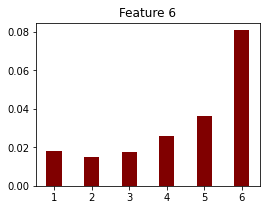

In [206]:
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(data['feature6']):
  a.append(x)
  b.append(sum(data['feature7'][data['feature6']==x]/len(data[data['feature6']==x])))
plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 6")
plt.show()

In [ ]:
# целе-вероятностное кодирование всех переменных
data['feature0_c']=0
for x in pd.unique(X_train['feature0']):
  data['feature0_c'][data['feature0']==x] = sum(y_train[X_train['feature0']==x]/len(X_train[X_train['feature0']==x]))

In [ ]:
data['feature1_c']=0
for x in pd.unique(X_train['feature1']):
  data['feature1_c'][data['feature1']==x] = sum(y_train[X_train['feature1']==x]/len(X_train[X_train['feature1']==x]))

In [ ]:
data['feature2_c']=0
for x in pd.unique(X_train['feature2']):
  data['feature2_c'][data['feature2']==x] = sum(y_train[X_train['feature2']==x]/len(X_train[X_train['feature2']==x]))

In [ ]:
data['feature3_c']=0
for x in pd.unique(X_train['feature3']):
  data['feature3_c'][data['feature3']==x] = sum(y_train[X_train['feature3']==x]/len(X_train[X_train['feature3']==x]))

In [ ]:
data['feature4_c']=0
for x in pd.unique(X_train['feature4']):
  data['feature4_c'][data['feature4']==x] = sum(y_train[X_train['feature4']==x]/len(X_train[X_train['feature4']==x]))

In [ ]:
data['feature5_c']=0
for x in pd.unique(X_train['feature5']):
  data['feature5_c'][data['feature5']==x] = sum(y_train[X_train['feature5']==x]/len(X_train[X_train['feature5']==x]))

In [ ]:
data['feature6_c']=0
for x in pd.unique(X_train['feature6']):
  data['feature6_c'][data['feature6']==x] = sum(y_train[X_train['feature6']==x]/len(X_train[X_train['feature6']==x]))

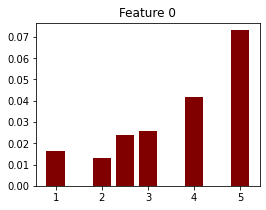

In [214]:
# результат коррекции переменной feature0
X_train['feature0'][X_train['feature0']==6] = 2.5
plt.figure(figsize=(4,3))
a,b=[],[]
for x in pd.unique(X_train['feature0']):
  a.append(x)
  b.append(sum(y_train[X_train['feature0']==x]/len(X_train[X_train['feature0']==x])))
  plt.bar(a, b, color ='maroon',
        width = 0.4)
plt.title("Feature 0")
plt.show()

In [215]:
# объединение всех созданных переменных с дамми-переменными
result = pd.concat([df, data.drop(['feature1','feature7'],axis=1)], axis=1)

## Модель

In [125]:
# Выделение таргета
y=result['feature7']
X=result.drop('feature7',axis=1)

In [126]:
# Разделение выборки на тренировочную (72%), валидационную (8%) и тестовую (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9, random_state=0)

In [127]:
# Удаление части выборки из тренировочной выборки для исправления несбалансированности данных
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.6, random_state=0)
X_train, y_train = under.fit_resample(X_train, y_train)

In [128]:
# Стандартизация значений
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Создана простая модель, с одним слоем и 128 нейронами и слоем "исключения" для регуляризации. Также в модель добавлен параметр _bias, который корректирует вывод модели на основе соотношения бинарных значений в выборке.

In [30]:
import tensorflow as tf
from tensorflow import keras

In [129]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          128, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.8),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [130]:
initial_bias = np.log([sum(y_train)/(len(y_train)-sum(y_train))])
initial_bias

array([-0.51071061])

In [131]:
model = make_model(output_bias=initial_bias)

In [132]:
# Выбрано оптимальное количество эпох (при большем количестве начинается переобучение), 
# при обучении на 1000 эпохах модель работает быстро, но со снижением качества
model.fit(X_train, y_train,epochs=4000,batch_size=512,validation_data=(X_valid, y_valid))

Выходные данные были обрезаны до нескольких последних строк (5000).
19/19 [==============================] - 0s 14ms/step - loss: 0.4906 - accuracy: 0.7581 - precision: 0.6868 - recall: 0.6527 - auc: 0.8261 - val_loss: 0.3865 - val_accuracy: 0.7900 - val_precision: 0.1174 - val_recall: 0.7018 - val_auc: 0.8201
Epoch 1502/4000
19/19 [==============================] - 0s 16ms/step - loss: 0.4904 - accuracy: 0.7571 - precision: 0.6840 - recall: 0.6547 - auc: 0.8257 - val_loss: 0.3852 - val_accuracy: 0.7879 - val_precision: 0.1173 - val_recall: 0.7098 - val_auc: 0.8204
Epoch 1503/4000
19/19 [==============================] - 0s 14ms/step - loss: 0.4841 - accuracy: 0.7611 - precision: 0.6909 - recall: 0.6567 - auc: 0.8316 - val_loss: 0.3920 - val_accuracy: 0.7851 - val_precision: 0.1165 - val_recall: 0.7150 - val_auc: 0.8206
Epoch 1504/4000
19/19 [==============================] - 0s 14ms/step - loss: 0.4889 - accuracy: 0.7568 - precision: 0.6850 - recall: 0.6509 - auc: 0.8280 - val_loss: 0

In [146]:
y_pred=model.predict(X_valid)>0.5

In [134]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [147]:
accuracy_score(y_valid, y_pred)

0.8004571201430984

In [148]:
roc_auc_score(y_valid, y_pred)

0.7518140522843763

In [149]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[7790, 1894],
       [ 114,  265]])

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      9684
           1       0.12      0.70      0.21       379

    accuracy                           0.80     10063
   macro avg       0.55      0.75      0.55     10063
weighted avg       0.95      0.80      0.86     10063



In [139]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid, y_pred))

[[7790 1894]
 [ 114  265]]


In [173]:
print('Коэффициент конверсии на валидационнй выборке: {}'.format(sum(y_valid)/len(y_valid)))
print('Коэффициент конверсии в данных, классифицированных как 1: {}'.format(sum(y_valid[(y_pred).reshape(1,-1)[0]])/len(y_valid[(y_pred).reshape(1,-1)[0]])))

Коэффициент конверсии на валидационнй выборке: 0.03766272483354864
Коэффициент конверсии в данных, классифицированных как 1: 0.12274201018990273


## Результат и интерпретация

Итоговая модель имеет приемлимые значения AUC (0.72) и точности (80%). 

Значения сопоставимы, но всё же значительно меньше чем в выбраной для сопоставления статье. Скорее всего, это связано тем, что процент конверсии в предоставленных данных значительно меньше - в 3 раза.

Как видно из отчета о классификации, модель имеет только одно плохое значение - точность предсказания единичных значений (0.12). То есть из всех значений, классифицированных как 1, только 12% классифицированы верно.

Таким образом, процент правильно классифицированных клиентов, совершивших заказ, равен 65. Неверно классифицируются 20% клиентов, не совершивших заказ.

In [143]:
y_pred_test=model.predict(X_test)>0.5

In [144]:
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_test)))
print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_test)))
print("Classification report:\n{}".format(classification_report(y_test, y_pred_test)))

Accuracy: 0.7954364763873429
ROC AUC: 0.7264550483521637
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     24163
           1       0.12      0.65      0.20       993

    accuracy                           0.80     25156
   macro avg       0.55      0.73      0.54     25156
weighted avg       0.95      0.80      0.86     25156



In [145]:
print(confusion_matrix(y_test, y_pred_test))

[[19363  4800]
 [  346   647]]


Коэффициент конверсии в данных, классифицированных как 1, увеличился в 3 раза по сравнению с изначальным.

In [174]:
print('Коэффициент конверсии на валидационнй выборке: {}'.format(sum(y_test)/len(y_test)))
print('Коэффициент конверсии в данных, классифицированных как 1: {}'.format(sum(y_test[(y_pred_test).reshape(1,-1)[0]])/len(y_test[(y_pred_test).reshape(1,-1)[0]])))

Коэффициент конверсии на валидационнй выборке: 0.039473684210526314
Коэффициент конверсии в данных, классифицированных как 1: 0.11878098035615936


## Другая модель

В процессе выбора модели была построена также вторая модель XGBClassifier, уступающая нейронной сети в качестве: метрика AUC уменьшилась с 0.75 до 0.73. Однако, ансамбли деревьев значительно более простая можель в оптимизации и более быстрая.

Первым шагом для создания модели так же является удаление части выборки. 

Далее отбираются только значимые признаки с помощью метода Permutation feature importance. К переменным добавлен столбец случайных значений, все переменные с важностью меньше чем у случайной переменной, удалены.

Наконец, гиперпараметры оптимизируются с помощью библиотеки optuna, которая объединяет несколько способов оптимизации.

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9, random_state=0)

In [71]:
# Ребалансировка выборки
over = SMOTE(sampling_strategy=0.1, random_state=0)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_, y_train_ = pipeline.fit_resample(X_train, y_train)

In [73]:
X_train_['random']=np.random.randint(2, size=26124)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
rf = RandomForestClassifier()
rf.fit(X_train_, y_train_)
# расчет важности переменных
results = permutation_importance(rf, X_train_, y_train_, n_repeats=10, scoring='roc_auc',n_jobs=-1)
importance = results.importances_mean

Feature: feature1, Score: 0.01850
Feature: feature0_1, Score: 0.00057
Feature: feature0_2, Score: 0.00294
Feature: feature0_3, Score: 0.00661
Feature: feature0_4, Score: 0.00430
Feature: feature0_5, Score: 0.00629
Feature: feature0_6, Score: 0.00260
Feature: feature2_11, Score: 0.00336
Feature: feature2_12, Score: 0.00473
Feature: feature2_13, Score: 0.00182
Feature: feature2_21, Score: 0.00002
Feature: feature2_22, Score: 0.00138
Feature: feature2_23, Score: 0.00085
Feature: feature3_1, Score: 0.00135
Feature: feature3_2, Score: 0.00067
Feature: feature3_3, Score: 0.00115
Feature: feature3_4, Score: 0.00060
Feature: feature4_0, Score: 0.00325
Feature: feature4_1, Score: 0.00398
Feature: feature4_2, Score: 0.00329
Feature: feature4_3, Score: 0.00141
Feature: feature4_4, Score: 0.00185
Feature: feature4_5, Score: 0.00104
Feature: feature4_6, Score: 0.00504
Feature: feature5_1, Score: 0.01381
Feature: feature5_2, Score: 0.02834
Feature: feature5_3, Score: 0.00629
Feature: feature5_4, Sco

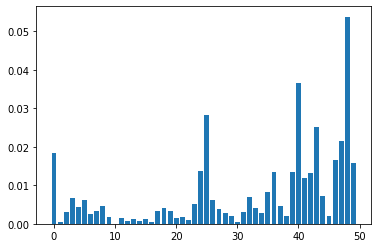

In [75]:
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (X_train_.columns[i],v))
# визуализация важности переменных
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [108]:
X1=X[['feature1', 'feature0','feature5', 
      'feature6','feature4','feature5_1', 'feature5_2','feature0_c',
      'feature1_c','feature4_c','feature5_c','feature6_c']]

In [175]:
X1.head()

,feature1,feature0,feature5,feature6,feature4,feature5_1,feature5_2,feature0_c,feature1_c,feature4_c,feature5_c,feature6_c
0,0,5.0,1,4,1.0,1,0,0.072113,0.042870,0.017204,0.077570,0.026842
1,1,2.0,6,1,1.0,0,0,0.014307,0.036463,0.017204,0.002692,0.017921
2,1,5.0,5,4,6.0,0,0,0.072113,0.036463,0.060657,0.004641,0.026842
3,1,3.0,4,1,1.0,0,0,0.026249,0.036463,0.017204,0.005942,0.017921
4,0,3.0,1,1,3.5,1,0,0.026249,0.042870,0.000000,0.077570,0.017921


In [176]:
# Формирование выборок с отобранными переменными
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.8, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9, random_state=0)

In [177]:
# Ребалансировка выборки
under = RandomUnderSampler(sampling_strategy=0.6)
X_train_, y_train_ = under.fit_resample(X_train, y_train)

In [80]:
from xgboost import XGBClassifier

In [ ]:
!pip install optuna

In [112]:
# Нахождение оптимальный параметров
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial, y_, X_):
    n_estimators = trial.suggest_int("n_estimators", 500, 5000)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 1)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 9)
    reg_alpha = trial.suggest_float("reg_alpha", 0.00001, 0.3)
    reg_lambda = trial.suggest_float("reg_lambda", 0.00001, 0.3)
   
    xgb = XGBClassifier(
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        n_jobs=-1, eval_metric='auc', random_state=0)
    score = cross_val_score(xgb, X_, y_, cv=3).mean()
    return score

In [113]:
study = optuna.create_study(direction = "maximize")
study.optimize(lambda trial: objective(
        trial,y_=y_train_, X_=X_train_), n_trials = 30)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-09-18 18:55:39,139] A new study created in memory with name: no-name-8c1494fd-4d35-4a5f-a582-0f46c992d663
[I 2022-09-18 18:56:08,558] Trial 0 finished with value: 0.7354974777585302 and parameters: {'n_estimators': 4501, 'learning_rate': 0.8897995084173511, 'min_child_weight': 7, 'reg_alpha': 0.05461650361176633, 'reg_lambda': 0.09117976742023032}. Best is trial 0 with value: 0.7354974777585302.
[I 2022-09-18 18:56:19,745] Trial 1 finished with value: 0.7391636529372301 and parameters: {'n_estimators': 1728, 'learning_rate': 0.2470824826318825, 'min_child_weight': 2, 'reg_alpha': 0.010957696177853886, 'reg_lambda': 0.27525701255362856}. Best is trial 1 with value: 0.7391636529372301.
[I 2022-09-18 18:56:34,840] Trial 2 finished with value: 0.7401343172579241 and parameters: {'n_estimators': 2355, 'learning_rate': 0.10806260799383317, 'min_child_weight': 9, 'reg_alpha': 0.07945899942410302, 'reg_lambda': 0.18752451416374824}. Best is trial 2 with value: 0.7401343172579241.
[I 20

Best Score:  0.7438001087886223
Best Params: 
  n_estimators: 2996
  learning_rate: 0.003993361162618836
  min_child_weight: 8
  reg_alpha: 0.15792437644877366
  reg_lambda: 0.11869541382022328


In [185]:
xgb = XGBClassifier(learning_rate = 0.003993361162618836, n_estimators=2996, min_child_weight=8, eval_metric='auc', random_state=0,
                      reg_alpha=0.15792437644877366, reg_lambda= 0.11869541382022328)
xgb.fit(X_train_, y_train_)

XGBClassifier(eval_metric='auc', learning_rate=0.003993361162618836,
              min_child_weight=8, n_estimators=2996,
              reg_alpha=0.15792437644877366, reg_lambda=0.11869541382022328)

In [186]:
y_pred_xgb=xgb.predict(X_valid)

In [187]:
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pred_xgb)))
print("ROC AUC: {}".format(roc_auc_score(y_valid, y_pred_xgb)))
print("Classification report:\n{}".format(classification_report(y_valid, y_pred_xgb)))

Accuracy: 0.8055251912948425
ROC AUC: 0.7392357058238218
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      9684
           1       0.12      0.67      0.21       379

    accuracy                           0.81     10063
   macro avg       0.55      0.74      0.55     10063
weighted avg       0.95      0.81      0.86     10063



In [188]:
print(confusion_matrix(y_valid, y_pred_xgb))

[[7853 1831]
 [ 126  253]]


In [189]:
y_pred_xgb_test=xgb.predict(X_test)

In [190]:
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_xgb_test)))
print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_xgb_test)))
print("Classification report:\n{}".format(classification_report(y_test, y_pred_xgb_test)))

Accuracy: 0.800445221815869
ROC AUC: 0.7247168535915796
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     24163
           1       0.12      0.64      0.20       993

    accuracy                           0.80     25156
   macro avg       0.55      0.72      0.54     25156
weighted avg       0.95      0.80      0.86     25156



In [191]:
print(confusion_matrix(y_test, y_pred_xgb_test))

[[19498  4665]
 [  355   638]]


## Итоговая таблица

***Accuracy***
\begin{array}{|c|c|} \hline
 & Validation & Test \\ \hline
NN & 80.0 & 79.5 \\
XGBClassifier & 80.5 & 80.0 \\ \hline
\end{array}

***AUC***
\begin{array}{|c|c|} \hline
 & Validation & Test \\ \hline
NN & .751 & .726 \\
XGBClassifier & .739 & .724 \\ \hline
\end{array}

Так как основной метрикой для отбора модели была площадь под кривой ROC, нейронная сеть является основной моделью. Однако, на тестовой выборке качество моделей по данной метрике совпадает. В то же время точность у нейронной сети чуть меньше.

## Возможности для улучшения моделей

В качестве возможных дальнейших улучшений, можно выделить следующие:

1.   Выделение и удаление выбросов
2.   Устранение мильтиколлинеарности и корреляции между независимыми переменными
3.   Более сложная коррекция переменных 
4.   Более сложный отбор переменных

